Copyright (C) 2019-2021  Martin Engqvist

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

### This Jupyter notebook analyzes 332 yeast genomes to find enzymes that act on carbohydrates

Analysis performed by Martin Engqvist (Chalmers University of Technology) in November 2019.


For the relative paths to work (which rely on the dotenv module) an empty file named exactly ".env" must be placed in the project base folders. If this is not done all the folder variables below will need to be defined manually.

In [1]:
import os
import sys
from dotenv import load_dotenv, find_dotenv # do 'pip install python-dotenv'
from os.path import join, dirname, basename, exists, isdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import subprocess

import Bio
from Bio import SeqIO


### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory
   


    
tempo_clustered_path = join(INTERMEDIATE, 'tempo_in_genome', 'fasta', '332_genome_annotations', 'pep_clustered')
if not exists(tempo_clustered_path):
    os.makedirs(tempo_clustered_path)  
    

In [2]:
print('Python version: %s' % (sys.version))
print('Pandas version: %s' % pd.__version__)
print('Re version: %s' % re.__version__)
print('BioPython version: %s' % Bio.__version__)

Python version: 3.7.7 (default, Sep 11 2020, 20:43:12) 
[GCC 7.3.0]
Pandas version: 1.0.3
Re version: 2.2.1
BioPython version: 1.76


### Notes
The fasta files used in this script have been pre-processed in the "de-duplication_of_genes.ipynb" notebook. The pre-processing removed all whitespace from the fasta headers and subsequently clustered the sequences using cd-hit in order to remove duplicate sequences within a genome.

### Analysis

#### Start by loading genome information

In [4]:
def norm_organism(orgname):
    '''
    Return abbreviated organism name
    '''
    orgname = orgname.replace('[', '').replace(']', '')
    
    # two organisms occur twice, deal with these special cases
    if orgname == 'Metschnikowia matae var. maris':
        return 'metschnikowia_matae_maris'
    
    elif orgname == 'Nadsonia fulvescens var. elongata':
        return 'nadsonia_fulvescens_var_elongata'
      
    # now parse filename for the others
    if orgname.startswith('yH'):
        organism = '_'.join(orgname.split()[1:3]).lower().replace('.', '')
    else:
        organism = '_'.join(orgname.split()[:2]).lower().replace('.', '')
    
    return organism



def norm_filename(filename):
    '''
    Return abbreviated organism name
    '''
    filename = filename.replace('[', '').replace(']', '')
    
    # two organisms occur twice, deal with these special cases
    if filename == 'metschnikowia_matae_maris.max.clustered.pep':
        return 'metschnikowia_matae_maris'
    
    elif filename == 'nadsonia_fulvescens_var_elongata.max.clustered.pep':
        return 'nadsonia_fulvescens_var_elongata'
    
    # now parse filename for the others
    if filename.startswith('yH'):
        file = '_'.join(filename.split('.')[0].split('_')[1:3]).lower()
    else:
        file = '_'.join(filename.split('.')[0].split('_')[:2]).lower()
    
    return file

    

# load up the data
genome_data = pd.read_csv(join(PROJ, 'doc', '332_yeast_genomes.csv'), sep='\t')

# normalize the organism names
genome_data['organism'] = genome_data.apply(lambda row: norm_organism(row['Species name']),axis=1)

display(genome_data.head())
display(genome_data.tail())
display(genome_data.describe())


,id,old_species_id,Species name,Common synonym,Major clade,Family,Genus,Strain sequenced,NRRL,CBS,...,GC%,Heterozygosity,CUG usage,BUSCO Complete,BUSCO Duplicated,BUSCO Fragmented,BUSCO Missing,Reference,Note,organism
0,1,Lipomyces_starkeyi,Lipomyces starkeyi,NaN,Lipomycetaceae,Lipomycetaceae,Lipomyces,NRRL Y-11557,Y-11557,NaN,...,46.92,Unknown,Leu,1566,11,126,56,"Riley R, et al. Comparative genomics of biotec...",NaN,lipomyces_starkeyi
1,4,yHMPu5000034758_Lipomyces_japonicus,Lipomyces japonicus,NaN,Lipomycetaceae,Lipomycetaceae,Lipomyces,NRRL Y-17848,Y-17848,7319.0,...,41.91,5.7E-05,Leu,1539,6,134,80,This study,NaN,lipomyces_japonicus
2,10,Tortispora_caseinolytica,Tortispora caseinolytica,NaN,Trigonopsidaceae,Trigonopsidaceae,Tortispora,NRRL Y-17796,Y-17796,7781.0,...,45.42,Unknown,Leu,1532,0,134,93,"Riley R, et al. Comparative genomics of biotec...",NaN,tortispora_caseinolytica
3,12,yHMPu5000035650_Trigonopsis_variabilis,Trigonopsis variabilis,NaN,Trigonopsidaceae,Trigonopsidaceae,Trigonopsis,NRRL Y-1579,Y-1579,1040.0,...,45.28,1.3E-05,Leu,1308,3,262,186,This study,NaN,trigonopsis_variabilis
4,16,Arxula_adeninivorans,Blastobotrys adeninivorans,NaN,Dipodascaceae/Trichomonascaceae,Trichomonascaceae,Blastobotrys,LS3,NaN,NaN,...,48.12,Unknown,Leu,1663,7,75,14,"Kunze G, et al. The complete genome of Blastob...",NaN,blastobotrys_adeninivorans


,id,old_species_id,Species name,Common synonym,Major clade,Family,Genus,Strain sequenced,NRRL,CBS,...,GC%,Heterozygosity,CUG usage,BUSCO Complete,BUSCO Duplicated,BUSCO Fragmented,BUSCO Missing,Reference,Note,organism
327,328,yHMPu5000034862_Zygotorulaspora_florentina,Zygotorulaspora florentina,NaN,Saccharomycetaceae,Saccharomycetaceae,Zygotorulaspora,NRRL Y-1560,Y-1560,746.0,...,40.97,2.8E-05,Leu,1702,5,39,13,This study,NaN,zygotorulaspora_florentina
328,329,yHMPu5000034710_Kluyveromyces_dobzhanskii,Kluyveromyces dobzhanskii,NaN,Saccharomycetaceae,Saccharomycetaceae,Kluyveromyces,NRRL Y-1974,Y-1974,2104.0,...,41.25,2.4E-05,Leu,1698,7,36,18,This study,NaN,kluyveromyces_dobzhanskii
329,330,yHMPu5000034709_Kluyveromyces_aestuarii,Kluyveromyces aestuarii,NaN,Saccharomycetaceae,Saccharomycetaceae,Kluyveromyces,NRRL YB-4510,YB-4510,4438.0,...,38.32,2.2E-05,Leu,1671,2,55,31,This study,NaN,kluyveromyces_aestuarii
330,331,yHMPu5000026256_Zygotorulaspora_mrakii,Zygotorulaspora mrakii,NaN,Saccharomycetaceae,Saccharomycetaceae,Zygotorulaspora,NRRL Y-12654,Y-12654,4218.0,...,39.90,Unknown,Leu,1432,3,35,289,This study,NaN,zygotorulaspora_mrakii
331,332,yHMPu5000026152_Torulaspora_franciscae,Torulaspora franciscae,NaN,Saccharomycetaceae,Saccharomycetaceae,Torulaspora,NRRL Y-17532,Y-17532,2926.0,...,45.05,1E-05,Leu,1714,8,29,8,This study,NaN,torulaspora_franciscae


,id,CBS,JCM,No. contigs/scaffolds,No. genes,Assembly size,N50,GC%,BUSCO Complete,BUSCO Duplicated,BUSCO Fragmented,BUSCO Missing
count,332.000000,278.000000,138.000000,332.000000,332.000000,3.320000e+02,3.320000e+02,332.0000,332.000000,332.000000,332.000000,332.000000
mean,166.500000,6424.077734,6761.065217,762.060241,5700.885542,1.293650e+07,7.523597e+05,40.5900,1606.445783,19.475904,70.801205,62.277108
std,95.984374,3665.903382,6064.816152,2056.990772,1043.295863,3.195237e+06,7.257416e+05,5.6630,148.537991,34.418730,51.235930,114.334915
min,1.000000,107.000000,1442.000000,4.000000,4162.000000,8.152740e+06,2.738000e+03,25.2000,739.000000,0.000000,12.000000,4.000000
25%,83.750000,2967.250000,1989.250000,39.250000,5060.000000,1.095436e+07,2.044210e+05,36.3450,1592.750000,5.000000,42.000000,14.000000
50%,166.500000,6539.500000,3733.500000,307.500000,5556.000000,1.209838e+07,5.117265e+05,41.1400,1648.500000,8.500000,62.000000,24.000000
75%,249.250000,8925.500000,9771.250000,716.000000,5983.500000,1.405018e+07,1.121786e+06,44.8225,1686.250000,14.250000,85.000000,50.000000
max,332.000000,14088.000000,31691.000000,28196.000000,12786.000000,2.583133e+07,4.956242e+06,53.9800,1735.000000,390.000000,526.000000,953.000000


#### Get genomes from tempo and mode of genome evolution paper

Paper doi: 10.1016/j.cell.2018.10.023

Data doi: 10.6084/m9.figshare.5854692

Figshare link: https://figshare.com/articles/Tempo_and_mode_of_genome_evolution_in_the_budding_yeast_subphylum/5854692

In [5]:
# collecte info for which file is where
all_info = {}


# get a list of all organisms
all_orgs = set([norm_organism(s) for s in genome_data['organism'].tolist()])

def get_from_tempo_files(wanted_orgs):
    
    filepath = tempo_clustered_path
    files = os.listdir(filepath)
    
    orgs_found = set([])
    for fi in files:
        
        if fi.endswith('.pep') or fi.endswith('.fasta'):
            
            norm_org = norm_filename(fi)

            if norm_org in wanted_orgs:
                orgs_found.add(norm_org)

                all_info[norm_org] = {}
                all_info[norm_org]['fasta'] = join(filepath, fi)
            
    return orgs_found



tempo_orgs_found = get_from_tempo_files(all_orgs)

tempo_orgs_not_found = all_orgs - tempo_orgs_found

print('Orgs with tempo genomes: ', len(tempo_orgs_found))
print('Orgs without genomes: ', len(tempo_orgs_not_found))

Orgs with tempo genomes:  306
Orgs without genomes:  26


In [6]:
print('Not found')
display(genome_data[genome_data['organism'].isin(tempo_orgs_found)])

print('Found')
display(genome_data[genome_data['organism'].isin(tempo_orgs_not_found)])

Not found


,id,old_species_id,Species name,Common synonym,Major clade,Family,Genus,Strain sequenced,NRRL,CBS,...,GC%,Heterozygosity,CUG usage,BUSCO Complete,BUSCO Duplicated,BUSCO Fragmented,BUSCO Missing,Reference,Note,organism
0,1,Lipomyces_starkeyi,Lipomyces starkeyi,NaN,Lipomycetaceae,Lipomycetaceae,Lipomyces,NRRL Y-11557,Y-11557,NaN,...,46.92,Unknown,Leu,1566,11,126,56,"Riley R, et al. Comparative genomics of biotec...",NaN,lipomyces_starkeyi
1,4,yHMPu5000034758_Lipomyces_japonicus,Lipomyces japonicus,NaN,Lipomycetaceae,Lipomycetaceae,Lipomyces,NRRL Y-17848,Y-17848,7319.0,...,41.91,5.7E-05,Leu,1539,6,134,80,This study,NaN,lipomyces_japonicus
2,10,Tortispora_caseinolytica,Tortispora caseinolytica,NaN,Trigonopsidaceae,Trigonopsidaceae,Tortispora,NRRL Y-17796,Y-17796,7781.0,...,45.42,Unknown,Leu,1532,0,134,93,"Riley R, et al. Comparative genomics of biotec...",NaN,tortispora_caseinolytica
3,12,yHMPu5000035650_Trigonopsis_variabilis,Trigonopsis variabilis,NaN,Trigonopsidaceae,Trigonopsidaceae,Trigonopsis,NRRL Y-1579,Y-1579,1040.0,...,45.28,1.3E-05,Leu,1308,3,262,186,This study,NaN,trigonopsis_variabilis
6,24,Sugiyamaella_lignohabitans,Sugiyamaella lignohabitans,NaN,Dipodascaceae/Trichomonascaceae,Trichomonascaceae,Sugiyamaella,CBS 10342,YB-1473,10342.0,...,44.86,Unknown,Leu,1654,9,83,13,"Bellasio M, et al. Complete genome sequence an...",NaN,sugiyamaella_lignohabitans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,328,yHMPu5000034862_Zygotorulaspora_florentina,Zygotorulaspora florentina,NaN,Saccharomycetaceae,Saccharomycetaceae,Zygotorulaspora,NRRL Y-1560,Y-1560,746.0,...,40.97,2.8E-05,Leu,1702,5,39,13,This study,NaN,zygotorulaspora_florentina
328,329,yHMPu5000034710_Kluyveromyces_dobzhanskii,Kluyveromyces dobzhanskii,NaN,Saccharomycetaceae,Saccharomycetaceae,Kluyveromyces,NRRL Y-1974,Y-1974,2104.0,...,41.25,2.4E-05,Leu,1698,7,36,18,This study,NaN,kluyveromyces_dobzhanskii
329,330,yHMPu5000034709_Kluyveromyces_aestuarii,Kluyveromyces aestuarii,NaN,Saccharomycetaceae,Saccharomycetaceae,Kluyveromyces,NRRL YB-4510,YB-4510,4438.0,...,38.32,2.2E-05,Leu,1671,2,55,31,This study,NaN,kluyveromyces_aestuarii
330,331,yHMPu5000026256_Zygotorulaspora_mrakii,Zygotorulaspora mrakii,NaN,Saccharomycetaceae,Saccharomycetaceae,Zygotorulaspora,NRRL Y-12654,Y-12654,4218.0,...,39.90,Unknown,Leu,1432,3,35,289,This study,NaN,zygotorulaspora_mrakii


Found


,id,old_species_id,Species name,Common synonym,Major clade,Family,Genus,Strain sequenced,NRRL,CBS,...,GC%,Heterozygosity,CUG usage,BUSCO Complete,BUSCO Duplicated,BUSCO Fragmented,BUSCO Missing,Reference,Note,organism
4,16,Arxula_adeninivorans,Blastobotrys adeninivorans,NaN,Dipodascaceae/Trichomonascaceae,Trichomonascaceae,Blastobotrys,LS3,NaN,NaN,...,48.12,Unknown,Leu,1663,7,75,14,"Kunze G, et al. The complete genome of Blastob...",NaN,blastobotrys_adeninivorans
5,17,Candida_apicola,Starmerella apicola,Candida apicola,Dipodascaceae/Trichomonascaceae,Dipodascaceae,Candida,NRRL Y-50540,Y-50540,NaN,...,45.23,Unknown,Leu,1374,7,143,235,"Vega-Alvarado L, et al. High-Quality Draft Gen...",NaN,starmerella_apicola
20,68,Dekkera_bruxellensis,Brettanomyces bruxellensis,Dekkera bruxellensis,Pichiaceae,Pichiaceae,Brettanomyces,CBS 2499,NaN,2499.0,...,39.94,Unknown,Leu,1516,27,121,95,"Piškur J, et al. The genome of wine yeast Dekk...",NaN,brettanomyces_bruxellensis
32,101,yHMPu5000034637_Ogataea_populiabae,Ogataea populialbae,NaN,Pichiaceae,Pichiaceae,Ogataea,NRRL Y-48632,Y-48632,11363.0,...,42.23,1.2E-05,Leu,1623,9,82,45,This study,NaN,ogataea_populialbae
40,127,Candida_homilentoma,Hyphopichia homilentoma,Candida homilentoma,CUG-Ser1,Debaryomycetaceae,Hyphopichia,JCM 1507,Y-10941,6312.0,...,49.52,Unknown,Ser,1702,4,48,5,This study,NaN,hyphopichia_homilentoma
43,133,Candida_tenuis,Yamadazyma tenuis,Candida tenuis,CUG-Ser1,Debaryomycetaceae,Yamadazyma,NRRL Y-1498,Y-1498,615.0,...,42.92,Unknown,Ser,1681,8,58,12,"Wohlbach DJ, et al. Comparative genomics of xy...",NaN,yamadazyma_tenuis
63,200,yHMPu5000035031_Candida_kruisii,Teunomyces kruisii,NaN,CUG-Ser1,Debaryomycetaceae,Teunomyces,NRRL Y-17087,Y-17087,6451.0,...,46.07,1E-06,Ser,1689,36,29,5,This study,NaN,teunomyces_kruisii
64,201,yHMPu5000035022_Candida_emberorum,Suhomyces emberorum,NaN,CUG-Ser1,Debaryomycetaceae,Suhomyces,NRRL Y-27606,Y-27606,9827.0,...,40.75,3E-06,Ser,1696,5,46,12,This study,NaN,suhomyces_emberorum
111,18,Candida_infanticola,Wickerhamiella infanticola,Candida infanticola,Dipodascaceae/Trichomonascaceae,Dipodascaceae,Wickerhamiella,DS02,NaN,NaN,...,48.32,Unknown,Leu,1477,10,147,125,"Lee H, et al. Genbank Accession IDs: LWLF01000...",NaN,wickerhamiella_infanticola
112,19,Candida_versatilis,Wickerhamiella versatilis,Candida versatilis,Dipodascaceae/Trichomonascaceae,Dipodascaceae,Wickerhamiella,JCM 5958,NaN,7511.0,...,45.04,Unknown,Leu,1437,7,158,157,This study,NaN,wickerhamiella_versatilis


#### Seems like some are not found because the old species name is used on the fasta files in some cases

In [7]:

missing_subset = genome_data[genome_data['organism'].isin(tempo_orgs_not_found)]

all_orgs_alt_names = set([])
for org in missing_subset['old_species_id'].tolist():
    all_orgs_alt_names.add(norm_filename(org))
        


tempo2_orgs_found = get_from_tempo_files(all_orgs_alt_names)

tempo2_orgs_not_found = all_orgs_alt_names - tempo2_orgs_found

print('Orgs with tempo genomes: ', len(tempo2_orgs_found))
print('Orgs without genomes: ', len(tempo2_orgs_not_found))

Orgs with tempo genomes:  26
Orgs without genomes:  0


## Run dbCan HMMs on the fasta files

#### First I need to download the HMMs

http://bcb.unl.edu/dbCAN2/

In [9]:

hmm_folder = join(RAW_EXTERNAL, 'dbcan')
hmm_file = join(hmm_folder, 'dbCAN-HMMdb-V8.txt')

if not exists(hmm_folder):
    os.makedirs(hmm_folder)

if not exists(hmm_file):
    # unzip the zipfile (which comes with the repository)
    hmm_zip_file = hmm_file.replace('.txt', '.zip')
    if exists(hmm_zip_file.replace('.txt', '.zip')):
        !unzip $hmm_zip_file
    
    # if it is not present download the file again
    else:
        url = 'http://bcb.unl.edu/dbCAN2/download/dbCAN-HMMdb-V8.txt'
        mycmd = 'wget %s -P %s' % (url, hmm_folder)
        os.system(mycmd)
    


Archive:  /data/Work/projects/yeast_carbohydrate_enz/data/raw_external/dbcan/dbCAN-HMMdb-V8.zip
  inflating: dbCAN-HMMdb-V8.txt      


#### Run the HMM on all genome fasta files

In [10]:
# get version
mycmd = 'hmmsearch -h | head -n 4'
print(subprocess.check_output(mycmd, shell=True))

# make folder if needed
outpath = join(INTERMEDIATE, 'hmm_output')
if not exists(outpath):
    os.makedirs(outpath)


# run hmmer on all fasta files    
dbcan_hmms = join(RAW_EXTERNAL, 'dbcan', 'dbCAN-HMMdb-V8.txt')
for org in sorted(all_info.keys()):
    fasta_file = all_info[org]['fasta']
    hmm_outfile = join(outpath, org+'.out')
    
    if not exists(hmm_outfile):
    
        mycmd = 'hmmsearch -E 1e-15 --domtblout %s %s %s > tmp.out' % (hmm_outfile, dbcan_hmms, fasta_file)
        os.system(mycmd)

    all_info[org]['hmm_out'] = hmm_outfile

print('Done')

b'# hmmsearch :: search profile(s) against a sequence database\n# HMMER 3.3.1 (Jul 2020); http://hmmer.org/\n# Copyright (C) 2020 Howard Hughes Medical Institute.\n# Freely distributed under the BSD open source license.\n'
Done


#### Run singalP on all genomes to get a signal peptide prediction

http://www.cbs.dtu.dk/services/SignalP/

SignalP version 5.0b Linux x86_64


In [11]:

# make folder if needed
outpath = join(INTERMEDIATE, 'signalp_output')
if not exists(outpath):
    os.makedirs(outpath)


# run signalP on all genomes
for org in sorted(all_info.keys()):
    fasta_file = all_info[org]['fasta']
    signalp_outfile = join(outpath, org+'.out')
    
    if not exists(signalp_outfile):
    
        mycmd = 'signalp -fasta %s -org euk -format short -stdout > %s' % (fasta_file, signalp_outfile)
        os.system(mycmd)
        
    all_info[org]['signalp_out'] = signalp_outfile


print('Done')




Done


#### Parse the outfiles and combine to a single data file

In [12]:

def parse_hmm_output(filepath, org):
    '''
    Parse an hmm output file and return as pandas data frame.
    '''
    data = {'organism':[], 'gene':[], 'hmm_model':[], 'hmm_model_len':[], 'hmm_match_from':[], 
            'hmm_match_to':[], 'hmm_match_coverage':[], 'match_evalue':[], 'gene_match_from':[], 
            'gene_match_to':[], 'enzyme':[], 'family':[], 'enzyme_type':[]}
    
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            
            parts = line.strip().split()
            gene = parts[0]
            
            hmm = parts[3]
            full_enzyme = hmm.split('.')[0]
            m = re.search('([A-Z]+)([0-9]+)[_]?([0-9]+)?', full_enzyme)
            family = m[1]+m[2]
            enzyme_type = m[1]

            evalue = parts[6]
            
            qlen = parts[5]
            hmm_from = parts[15]
            hmm_to = parts[16]
            coverage = (int(hmm_to)-int(hmm_from))/int(qlen)
            
            ali_from = parts[17]
            ali_to = parts[18]
            
            if coverage >= 0.35:
                data['organism'].append(org)
                data['gene'].append(gene)
                
                data['hmm_model'].append(hmm)
                data['hmm_model_len'].append(qlen)
                data['hmm_match_from'].append(hmm_from)
                data['hmm_match_to'].append(hmm_to)
                data['hmm_match_coverage'].append('%.2f' % float(coverage))
                data['match_evalue'].append(evalue)
                data['gene_match_from'].append(ali_from)
                data['gene_match_to'].append(ali_to)

                data['enzyme'].append(full_enzyme)   
                data['family'].append(family)            
                data['enzyme_type'].append(enzyme_type)          
   
            
    return pd.DataFrame(data)
           

    
def parse_signalp_output(filepath, org):
    '''
    Parse an signalP output file and return as pandas data frame.
    '''
    data = {'organism':[], 'gene':[], 'signal_peptide':[], 'signal_peptide_prob':[],
            'sp_cut_pos':[], 'sp_cut_seq':[], 'sp_cut_prob':[]}

    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue

            parts = line.strip().split('\t')
            gene = parts[0]
            sp_or_not = parts[1]
            pred_sp = parts[2]
            pred_other = parts[3]

            
            if sp_or_not != 'OTHER':
                
                # find signal peptide cut-site info
                m = re.search('CS pos: ([0-9]+[-][0-9]+)[.] ([A-Z]+[-][A-Z]+)[.] Pr: ([01]+[.][0-9]+)', parts[4])
                
                if m is None:
                    cut_pos = 'N/A'
                    cut_seq = 'N/A'
                    cut_pval = 'N/A'
                
                else:
                    cut_pos = m[1]
                    cut_seq = m[2]
                    cut_pval = m[3]
                
            else:
                cut_pos = 'N/A'
                cut_seq = 'N/A'
                cut_pval = 'N/A'
         
            data['organism'].append(org)
            data['gene'].append(gene)
            data['signal_peptide'].append(sp_or_not)
            data['signal_peptide_prob'].append(pred_sp)
            data['sp_cut_pos'].append(cut_pos)
            data['sp_cut_seq'].append(cut_seq)
            data['sp_cut_prob'].append(cut_pval)

    return pd.DataFrame(data)




def get_fasta_gene_number(filepath, org):
    '''
    For an organism count the number of genes in fasta file.
    '''
    data = {'organism':[], 'genes_in_fasta':[]}
    counter = 0
    for record in SeqIO.parse(filepath, "fasta"):
        counter += 1
        
    data['organism'].append(org)
    data['genes_in_fasta'].append(counter)
    
    return pd.DataFrame(data)
    

        
all_genome_data = None
for organism in sorted(all_info.keys()):

    # parse outputs
    hmm_data = parse_hmm_output(all_info[organism]['hmm_out'], organism)
    signalp_data = parse_signalp_output(all_info[organism]['signalp_out'], organism)
    fasta_data = get_fasta_gene_number(all_info[organism]['fasta'], organism)

    
    # merge the data frames 
    hmm_data = hmm_data.merge(signalp_data, on=['organism', 'gene'], how='left')
    hmm_data = hmm_data.merge(fasta_data, on='organism', how='left')
    

    # add to the main data 
    if all_genome_data is None:
        all_genome_data = hmm_data
    else:
        all_genome_data = all_genome_data.append(hmm_data)

        
# apparently CAZy has removed GH10, so let's remove that from the data before saving
all_genome_data = all_genome_data[all_genome_data.family!='GH10']
    
display(all_genome_data.head())
display(all_genome_data.tail())
display(all_genome_data.describe())

# write file to disk
all_genome_data.to_csv(join(FINAL, '332_yeast_genomes_enzyme_info_version_2.tsv'), sep='\t', index=False)

,organism,gene,hmm_model,hmm_model_len,hmm_match_from,hmm_match_to,hmm_match_coverage,match_evalue,gene_match_from,gene_match_to,enzyme,family,enzyme_type,signal_peptide,signal_peptide_prob,sp_cut_pos,sp_cut_seq,sp_cut_prob,genes_in_fasta
0,aciculoconidium_aculeatum,augustus_masked-NODE_13_length_332279_cov_34.6...,CBM21.hmm,107,2,107,0.98,1.8e-31,355,480,CBM21,CBM21,CBM,OTHER,0.001684,N/A,N/A,N/A,6944
1,aciculoconidium_aculeatum,snap_masked-NODE_98_length_34288_cov_31.3655_I...,CBM21.hmm,107,3,107,0.97,2.8e-22,265,371,CBM21,CBM21,CBM,OTHER,0.000843,N/A,N/A,N/A,6944
2,aciculoconidium_aculeatum,augustus_masked-NODE_42_length_144261_cov_33.5...,CBM43.hmm,83,1,82,0.98,6.4e-21,372,457,CBM43,CBM43,CBM,SP(Sec/SPI),0.995878,19-20,VSA-AD,0.8042,6944
3,aciculoconidium_aculeatum,augustus_masked-NODE_97_length_34420_cov_46.27...,CBM43.hmm,83,1,82,0.98,3e-20,380,465,CBM43,CBM43,CBM,SP(Sec/SPI),0.922542,22-23,ALA-NN,0.6326,6944
4,aciculoconidium_aculeatum,augustus_masked-NODE_3_length_592973_cov_34.37...,CE10.hmm,341,93,286,0.57,1.4e-19,96,322,CE10,CE10,CE,OTHER,0.025548,N/A,N/A,N/A,6944


,organism,gene,hmm_model,hmm_model_len,hmm_match_from,hmm_match_to,hmm_match_coverage,match_evalue,gene_match_from,gene_match_to,enzyme,family,enzyme_type,signal_peptide,signal_peptide_prob,sp_cut_pos,sp_cut_seq,sp_cut_prob,genes_in_fasta
189,zygotorulaspora_mrakii,genemark-NODE_4_length_587279_cov_18.5498_ID_5...,GH5_54.hmm,263,2,236,0.89,5.4e-22,92,370,GH5_54,GH5,GH,SP(Sec/SPI),0.934510,23-24,VNG-LD,0.9126,4757
190,zygotorulaspora_mrakii,genemark-NODE_1_length_1100707_cov_17.8797_ID_...,GH5_54.hmm,263,9,255,0.94,3.6e-19,87,349,GH5_54,GH5,GH,OTHER,0.001628,N/A,N/A,N/A,4757
191,zygotorulaspora_mrakii,genemark-NODE_3_length_705464_cov_18.5159_ID_3...,GH5_9.hmm,303,2,303,0.99,3.4e-124,112,417,GH5_9,GH5,GH,SP(Sec/SPI),0.900421,20-21,AVS-SP,0.5682,4757
192,zygotorulaspora_mrakii,genemark-NODE_4_length_587279_cov_18.5498_ID_5...,GH5_9.hmm,303,1,303,1.00,1e-113,107,451,GH5_9,GH5,GH,SP(Sec/SPI),0.934510,23-24,VNG-LD,0.9126,4757
193,zygotorulaspora_mrakii,genemark-NODE_1_length_1100707_cov_17.8797_ID_...,GH5_9.hmm,303,1,231,0.76,5.1e-35,94,331,GH5_9,GH5,GH,OTHER,0.001628,N/A,N/A,N/A,4757


,genes_in_fasta
count,85211.000000
mean,5774.603666
std,1061.953000
min,4128.000000
25%,5111.000000
50%,5565.000000
75%,6131.000000
max,11757.000000


### There are sometimes several predictions for the same region of a protein, but we only want to keep one.

#### First figure out what the cutoff should be in terms of what is an overlap.

Unfiltered domain number: 85211


/home/martin/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/home/martin/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


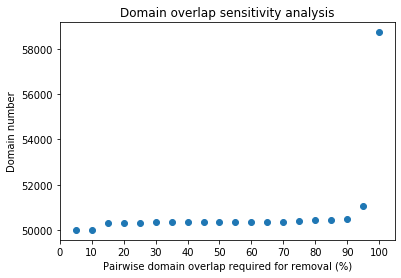

In [11]:
def test_overlap(pos1, pos2, cutoff):
    '''
    Find out whether two defined regions overlap or not.
    Overlap is defined True when at least one of the domains 
    overlap with the other above a certain fraction of the whole.
    '''
    pos1 = [int(s) for s in pos1]
    pos2 = [int(s) for s in pos2]
    both_pairs = sorted([pos1, pos2])
    
    # simplest case, they do not overlap at all
    if both_pairs[0][1] < both_pairs[1][0]:
        return False
    
    else:
        # get overlap part
        overlap_region = both_pairs[0][1] - both_pairs[1][0]
        
        # fraction of first domain
        frac_first = overlap_region / (both_pairs[0][1] - both_pairs[0][0])
                          
        # fraction of second domain
        frac_second = overlap_region / (both_pairs[1][1] - both_pairs[1][0])
        
        if max(frac_first, frac_second) > cutoff:
            #print(both_pairs, True, max(frac_first, frac_second))
            return True
        else:
            #print(both_pairs, False, max(frac_first, frac_second))
            return False
    

    
    
def remove_overlaps(data, cutoff):
    '''
    When domains overlap (as defined by the cutoff level), 
    keep only the domain with the best e-value score.
    '''
    overlaps = [True]
    while any(overlaps):
        
        start_end_pairs = list(zip(data.gene_match_from.values, data.gene_match_to.values))
        e_vals = data.match_evalue.values
        e_vals = e_vals.astype(np.float) 

        
        for i in range(len(start_end_pairs)):
            overlaps = []
            for j in range(len(start_end_pairs[i+1:])):

                overlaps.append(test_overlap(start_end_pairs[i], start_end_pairs[i+1+j], cutoff))

            # prepend true or false for the first sequence, depending on whether there was an overlap
            if any(overlaps):
                overlaps = [False for s in range(i)] + [True] + overlaps

                # from the ones with an overlap, what is the position of the one with the lowest e-value
                overlap_e_vals = e_vals[overlaps]

                idx = overlap_e_vals.argmin()
                #print(overlaps)
                #print(overlap_e_vals)
                #print(i+idx)


                # flip the one that said true but had the smallest e-value
                overlaps[i+idx] = False

                # invert the list to flip True vs False
                overlaps = [not i for i in overlaps]

                # filter the data to keep all the ones that originally said False, but now say true
                data = data[overlaps]
                #print(data)
                break
                
    return data


    
# test a range of cutoff values to figure out which one is best
cutoff_vals = [s/100 for s in range(5, 105, 5)]
motifs = []
for cutoff in cutoff_vals:
    non_redundant_data = all_genome_data.groupby('gene').apply(lambda x: remove_overlaps(x, cutoff=cutoff))
    motifs.append(non_redundant_data.gene.count())


print('Unfiltered domain number: %s' % all_genome_data.gene.count())



# plot the data
plt.scatter([s * 100 for s in cutoff_vals], motifs)
plt.xlabel('Pairwise domain overlap required for removal (%)')
plt.ylabel('Domain number')
plt.xticks(np.arange(0, 100+10, 10))
plt.title('Domain overlap sensitivity analysis')


plt.savefig('./figures/domain_sensitivity_analysis.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.savefig('./figures/domain_sensitivity_analysis.pdf', facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

### Now remove redundant domains using the most appropriate cutoff

In [12]:
# filter out overlapping domains using pre-determined cutoff value
non_redundant_data = all_genome_data.groupby('gene').apply(lambda x: remove_overlaps(x, cutoff=0.2))

# write file to disk
non_redundant_data.to_csv(join(FINAL, '332_yeast_genomes_enzyme_info_version_3.tsv'), sep='\t', index=False)

### Output a table with the number of domains per organism

In [13]:
# keep only relevant columns and count the enzyme class occurances
heatmap_data = non_redundant_data[['organism', 'enzyme', 'family']]
heatmap_data_count = heatmap_data.groupby(['organism', 'family']).count().reset_index()

# rename columns and cast to wide format
heatmap_data_count = heatmap_data_count.rename(columns={'organism': 'organism', 'family':'family', 'enzyme':'count'})
heatmap_data_count = heatmap_data_count.pivot_table(index=['organism'], columns='family', values='count').reset_index()

# replace NaN with 0
heatmap_data_count = heatmap_data_count.fillna(0)


display(heatmap_data_count.head())
display(heatmap_data_count.tail())
display(heatmap_data_count.describe())


heatmap_data_count.to_csv(join(FINAL, '332_yeast_genomes_heatmap_data.tsv'), sep='\t', index=False)

family,organism,AA1,AA11,AA2,AA3,AA4,AA5,AA6,AA7,AA9,...,GT83,GT90,GT91,PL1,PL26,PL3,PL33,PL35,PL4,PL7
0,aciculoconidium_aculeatum,5.0,0.0,1.0,1.0,4.0,0.0,7.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
1,alloascoidea_hylecoeti,3.0,0.0,4.0,0.0,4.0,0.0,4.0,1.0,2.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ambrosiozyma_ambrosiae,6.0,0.0,2.0,0.0,2.0,0.0,5.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ambrosiozyma_kashinagacola,5.0,0.0,2.0,0.0,4.0,0.0,3.0,1.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ambrosiozyma_maleeae,4.0,0.0,2.0,0.0,2.0,0.0,4.0,1.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


family,organism,AA1,AA11,AA2,AA3,AA4,AA5,AA6,AA7,AA9,...,GT83,GT90,GT91,PL1,PL26,PL3,PL33,PL35,PL4,PL7
327,zygosaccharomyces_bisporus,5.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
328,zygosaccharomyces_kombuchaensis,4.0,0.0,2.0,1.0,2.0,0.0,3.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329,zygosaccharomyces_rouxii,4.0,0.0,1.0,2.0,3.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
330,zygotorulaspora_florentina,5.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,zygotorulaspora_mrakii,4.0,0.0,2.0,0.0,2.0,0.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


family,AA1,AA11,AA2,AA3,AA4,AA5,AA6,AA7,AA9,CBM1,...,GT83,GT90,GT91,PL1,PL26,PL3,PL33,PL35,PL4,PL7
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,...,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,3.358434,0.048193,1.472892,0.740964,2.686747,0.030120,2.954819,1.096386,0.099398,0.846386,...,0.006024,0.141566,2.066265,0.075301,0.033133,0.015060,0.009036,0.009036,0.072289,0.030120
std,1.397393,0.228147,0.774901,1.001091,1.304676,0.217781,1.155994,0.751465,0.586144,2.228059,...,0.077498,1.025868,2.954101,0.619710,0.195381,0.121976,0.122572,0.094771,0.281692,0.496814
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,2.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,2.000000,1.000000,4.000000,0.000000,3.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,2.000000,5.000000,6.000000,7.000000,3.000000,8.000000,6.000000,7.000000,16.000000,...,1.000000,12.000000,19.000000,9.000000,2.000000,1.000000,2.000000,1.000000,2.000000,9.000000
